In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns

# Engine

## Exponential function

In [3]:
def pexp(lambda_, x):
    """ PDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the x value of the distribution. Intuitively,
        for example the time that has passed since the previous event

    Returns:
        float: the probability density at that x. Intuitively,
        for example the probability of having an event at time x
    """
    return lambda_* np.exp(-lambda_ * x)

def dexp(lambda_, x):
    """ CDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the x value of the distribution. Intuitively,
        for example the time that has passed since the previous event

    Returns:
        float: the cumulative probability of all values between 0 and x,
        inclusive. 
        Intuitively, for example the probability of having an event 
        at any time before and including x
    """
    return -1 * np.exp(-lambda_ * x)

def rexp(lambda_):
    """ Draw values from the exponential distribution
    This will be done through the Inverse Transform sampling Method.
    So we want to find a number x for which FX(x) = U; where X is a 
    random variable (exponential variable in this case) and U is a 
    uniform random variable and FX its distribution function 
    (exponential distribution in this case). So this means that to find x
    (the goal of this whole function) we need to solve for x = F^(-1)_x(U).
    
    So the steps are:
    - calculate the inverse of the exponential CDF: F^(-1)_x
    - draw a uniform random probability U (from the interval [0,1], of course)
    - calculate x = F^(-1)_x(U)

    Args:
        lambda_ (int): the rate

    Returns:
        float: a random exponential variable
    """
    u = np.random.uniform(low=0, high=1, size=1)
    t = (-1/lambda_) * np.log(u)
    return t.item()

## Test exponential random variable generation

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.27714692705466637, pvalue=2.1358475253382983e-68, statistic_location=1.492308099212895, statistic_sign=-1)

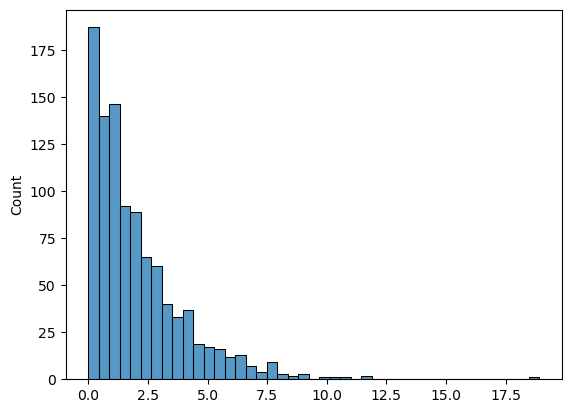

In [4]:
to_test = [rexp(0.5) for i in range(1000)]
sns.histplot(to_test)
stats.kstest(to_test, "expon")

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.045, pvalue=0.26347172719864703, statistic_location=0.9209260958488238, statistic_sign=-1)

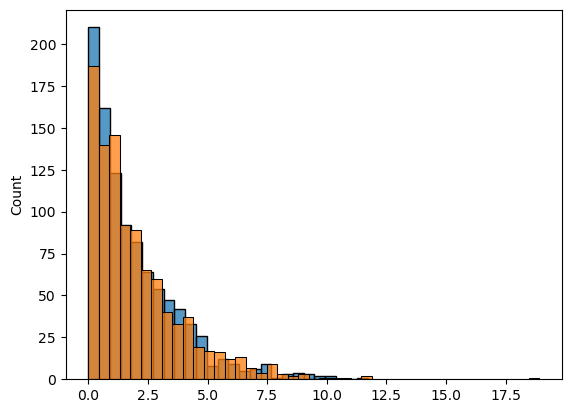

In [5]:
r = stats.expon.rvs(size=1000, scale=1/0.5)
sns.histplot(r)
sns.histplot(to_test)
stats.kstest(to_test, r)

## Simulation engine

In [ ]:
def simulation(L, T, LT, k_bind, k_dissociate, t_end=1, n_steps=100):
    r_bind = k_bind * L * T
    r_dissociate = k_dissociate * LT

    r_total = r_bind + r_dissociate
    p_LT = r_bind / r_total
    p_L_T = r_dissociate / r_total

    t = 0

    # time_bind = rexp(lambda_=r_bind)
    # time_dissociate = rexp(lambda_=r_dissociate)


# Simulate with physiological constants

In [ ]:
k_bind = 0.0146
k_dissociate = 35

L = 10000
T = 7000
LT = 0